In [13]:

import pandas as pd


file_path = "/content/221101769_samira.csv"
df = pd.read_csv(file_path)


print("Dataset Preview:")
df.head()


Dataset Preview:


,review,rating,timestamp,author,language,movie_id,title,media_type
0,This maybe hit the cinemas a month too early a...,5.0,2024-10-14T05:01:31.886Z,CinemaSerf,unknown,1034541,Terrifier 3,movie
1,"Just as violent, just not as entertaining.\r\n...",6.0,2024-10-25T09:27:10.151Z,r96sk,unknown,1034541,Terrifier 3,movie
2,A solid enough send off for this <em>'Venom'</...,6.0,2024-10-25T18:25:18.286Z,r96sk,unknown,912649,Venom: The Last Dance,movie
3,The other two at the very least were enjoyable...,4.0,2024-10-27T14:01:38.601Z,Mangoturtle,unknown,912649,Venom: The Last Dance,movie
4,Perhaps this was just one sequel too many as t...,6.0,2024-10-31T11:02:06.190Z,CinemaSerf,unknown,912649,Venom: The Last Dance,movie


In [14]:

print("Column Names in the Dataset:")
print(df.columns)


Column Names in the Dataset:
Index(['review', 'rating', 'timestamp', 'author', 'language', 'movie_id',
       'title', 'media_type'],
      dtype='object')


In [15]:

df = df.dropna(subset=['rating'])
df['rating'] = df['rating'].astype(float)

fixed_min_rating = 0  
fixed_max_rating = 10  

normalized_ratings = ((df['rating'] - fixed_min_rating) / (fixed_max_rating - fixed_min_rating)).clip(0, 1)


df['adjusted_rating'] = pd.cut(
    normalized_ratings,
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],  
    labels=[1, 2, 3, 4, 5],             
    include_lowest=True               
).astype(int)


print("Original Ratings and Final Adjusted Ratings:")
print(df[['rating', 'adjusted_rating']].head())


df.to_csv("adjusted_dataset_fixed_range.csv", index=False)


Original Ratings and Final Adjusted Ratings:
   rating  adjusted_rating
0     5.0                3
1     6.0                3
2     6.0                3
3     4.0                2
4     6.0                3


<ipython-input-15-26b464869275>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['rating'].astype(float)
<ipython-input-15-26b464869275>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adjusted_rating'] = pd.cut(


In [16]:

tnu = df['author'].nunique()  
tni = df['movie_id'].nunique()  
ratings_per_item = df.groupby('movie_id')['adjusted_rating'].count()

print(f"Total Number of Users (tnu): {tnu}")
print(f"Total Number of Items (tni): {tni}")
print("Ratings per Item (Top 5):")
print(ratings_per_item.head())


Total Number of Users (tnu): 56
Total Number of Items (tni): 19
Ratings per Item (Top 5):
movie_id
124364     4
153312     1
335983    11
354912     5
420634     5
Name: adjusted_rating, dtype: int64


In [17]:

user_ratings_count = df.groupby('author')['movie_id'].count()


active_users = {}
remaining_users = user_ratings_count.copy()


active_users["2_missing"] = remaining_users[remaining_users < tni - 2].index[0]
remaining_users = remaining_users.drop(active_users["2_missing"])

active_users["3_missing"] = remaining_users[remaining_users < tni - 3].index[0]
remaining_users = remaining_users.drop(active_users["3_missing"])


active_users["5_missing"] = remaining_users[remaining_users < tni - 5].index[0]

print("Selected Active Users:")
print(active_users)


Selected Active Users:
{'2_missing': 'Ahmad', '3_missing': 'Alex', '5_missing': 'BiankaMalburg'}


In [18]:

item_ratings_count = df.groupby('movie_id')['author'].count()


threshold_4 = 0.04 * tnu  
threshold_10 = 0.10 * tnu  


target_items = item_ratings_count[
    (item_ratings_count < threshold_10) & (item_ratings_count > threshold_4)
].head(2).index

print("Selected Target Items:")
print(target_items)


Selected Target Items:
Index([124364, 354912], dtype='int64', name='movie_id')


In [19]:

min_ratings_threshold = 5

user_ratings_count = df.groupby('author')['movie_id'].count()
active_users = user_ratings_count[user_ratings_count >= min_ratings_threshold].head(3).index

print("Active Users with Sufficient Ratings:")
print(active_users)


Active Users with Sufficient Ratings:
Index(['CinemaSerf', 'Manuel São Bento', 'r96sk'], dtype='object', name='author')


In [20]:
for user in active_users:
    user_ratings_count = df[df['author'] == user]['movie_id'].count()
    print(f"User {user} has rated {user_ratings_count} items.")


User CinemaSerf has rated 15 items.
User Manuel São Bento has rated 6 items.
User r96sk has rated 11 items.


In [21]:
co_rated_data = []

for user in active_users:
    user_ratings = df[df['author'] == user]

    for item in target_items:
        co_rated_users = df[df['movie_id'] == item]['author']
        no_common_users = len(set(co_rated_users))
        no_coRated_items = len(user_ratings)

        co_rated_data.append([user, item, no_common_users, no_coRated_items])

co_rated_df = pd.DataFrame(
    co_rated_data,
    columns=["Active_User", "Target_Item", "No_common_users", "No_coRated_items"]
)

sorted_co_rated_df = co_rated_df.sort_values(
    by=["No_common_users", "No_coRated_items"],
    ascending=False
)

print("Updated Co-Rated Statistics:")
print(sorted_co_rated_df)


Updated Co-Rated Statistics:
        Active_User  Target_Item  No_common_users  No_coRated_items
1        CinemaSerf       354912                5                15
5             r96sk       354912                5                11
3  Manuel São Bento       354912                5                 6
0        CinemaSerf       124364                4                15
4             r96sk       124364                4                11
2  Manuel São Bento       124364                4                 6


In [24]:

user_item_matrix = df.pivot_table(index='author', columns='movie_id', values='adjusted_rating').fillna(0)


In [26]:
import pandas as pd
import numpy as np  


user_item_matrix = df.pivot_table(index='author', columns='movie_id', values='adjusted_rating').fillna(0)

if isinstance(user_item_matrix, np.ndarray):
    user_item_matrix = pd.DataFrame(user_item_matrix)

print("User-Item Matrix successfully converted to DataFrame.")


User-Item Matrix successfully converted to DataFrame.


In [27]:
import numpy as np
import pandas as pd

threshold_30_percent = 0.3 * tni
co_rated_users_count = []


valid_active_users = [user for user in active_users if user in user_item_matrix.index]



for user in valid_active_users:
    
    co_rated_count = (user_item_matrix > 0).sum(axis=1) 
    max_users = np.sum(co_rated_count >= threshold_30_percent)  
    co_rated_users_count.append([user, max_users])

co_rated_users_df = pd.DataFrame(co_rated_users_count, columns=["Active_User", "Max_CoRated_Users"])

print("Maximum Users Co-Rating at Least 30% of Items:")
print(co_rated_users_df)


Maximum Users Co-Rating at Least 30% of Items:
        Active_User  Max_CoRated_Users
0        CinemaSerf                  3
1  Manuel São Bento                  3
2             r96sk                  3


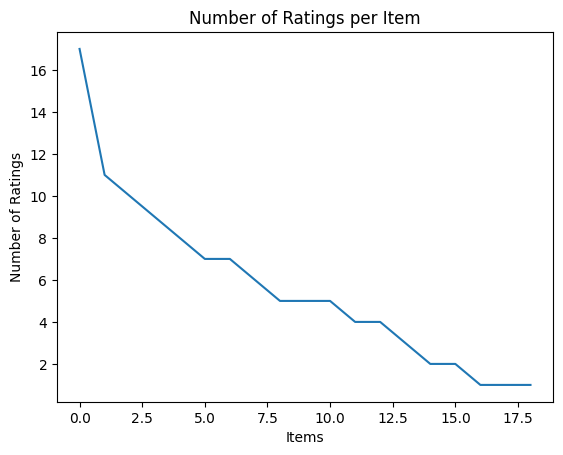

In [28]:
import matplotlib.pyplot as plt


ratings_per_item_sorted = ratings_per_item.sort_values(ascending=False)
plt.plot(ratings_per_item_sorted.values)
plt.title("Number of Ratings per Item")
plt.xlabel("Items")
plt.ylabel("Number of Ratings")
plt.show()


# Case Study 1.1: Cosine Similarity Without Mean-Centering

# 1.1.1: Compute Cosine Similarity

In [31]:

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np


cosine_sim_matrix = cosine_similarity(user_item_matrix)
np.fill_diagonal(cosine_sim_matrix, 0)  


cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)


print("Cosine Similarity Matrix (No Mean-Centering):")
print(cosine_sim_df.head())


Cosine Similarity Matrix (No Mean-Centering):
author          Ahmad  Alex  BiankaMalburg  Brent Marchant  Cal  \
author                                                            
Ahmad             0.0   1.0            0.0             0.0  0.0   
Alex              1.0   0.0            0.0             0.0  0.0   
BiankaMalburg     0.0   0.0            0.0             0.5  0.0   
Brent Marchant    0.0   0.0            0.5             0.0  0.0   
Cal               0.0   0.0            0.0             0.0  0.0   

author          Carlos G Diaz  Chandler Danier  Chris Sawin  CinemaSerf  \
author                                                                    
Ahmad                     0.0              0.0     0.000000    0.000000   
Alex                      0.0              0.0     0.000000    0.000000   
BiankaMalburg             0.0              0.0     0.000000    0.258199   
Brent Marchant            0.0              0.0     0.282843    0.516398   
Cal                       0.0     

# 1.1.2: Top 20% Closest Users

In [32]:
top_k = int(0.2 * len(user_item_matrix)) 
top_users = {
    user: cosine_sim_df.loc[user].nlargest(top_k).index.tolist()
    for user in user_item_matrix.index
}

print("Top 20% Closest Users Without Mean-Centering:")

for user, neighbors in list(top_users.items())[:5]:
    print(f"User {user}: Closest Neighbors {neighbors}")



Top 20% Closest Users Without Mean-Centering:
User Ahmad: Closest Neighbors ['Alex', 'SenkaM', 'StudiedAsleep', 'Ahmad', 'BiankaMalburg', 'Brent Marchant', 'Cal', 'Carlos G Diaz', 'Chandler Danier', 'Chris Sawin', 'CinemaSerf']
User Alex: Closest Neighbors ['Ahmad', 'SenkaM', 'StudiedAsleep', 'Alex', 'BiankaMalburg', 'Brent Marchant', 'Cal', 'Carlos G Diaz', 'Chandler Danier', 'Chris Sawin', 'CinemaSerf']
User BiankaMalburg: Closest Neighbors ['good.film', 'Brent Marchant', 'Manuel São Bento', 'CinemaSerf', 'Ahmad', 'Alex', 'BiankaMalburg', 'Cal', 'Carlos G Diaz', 'Chandler Danier', 'Chris Sawin']
User Brent Marchant: Closest Neighbors ['aGoryLouie', 'good.film', 'Manuel São Bento', 'CinemaSerf', 'BiankaMalburg', 'DonGable', 'Pringo', 'Sean', 'YearOneFun', 'albuainain', 'biancarockr']
User Cal: Closest Neighbors ['DallasBob', 'Henry', "RADIO1'S MR. MOVIE!-MAD AMI 🌠", 'garethmb', 'JPV852', 'Martha', 'Chris Sawin', 'r96sk', 'CinemaSerf', 'Ahmad', 'Alex']


# 1.1.3: Predict Ratings

In [33]:
def predict_ratings(user, similarity_df, matrix, top_users):
    predictions = {}
    neighbors = top_users[user]

    for item in matrix.columns:
        if matrix.loc[user, item] == 0:  
            neighbor_ratings = matrix.loc[neighbors, item]
            weights = similarity_df.loc[user, neighbors]
            predictions[item] = np.dot(weights, neighbor_ratings) / weights.sum()
    return predictions


for user in top_users.keys():
    predictions = predict_ratings(user, cosine_sim_df, user_item_matrix, top_users)
    print(f"User {user} Predictions: {predictions}")


User Ahmad Predictions: {153312: 0.0, 335983: 0.0, 354912: 0.0, 420634: 0.0, 519182: 0.0, 533535: 0.0, 580489: 0.0, 698687: 0.0, 889737: 0.0, 912649: 0.0, 933260: 0.0, 945961: 0.0, 1022789: 0.0, 1029235: 0.0, 1034541: 0.0, 1051896: 0.0, 1084736: 0.0, 1184918: 0.0}
User Alex Predictions: {153312: 0.0, 335983: 0.0, 354912: 0.0, 420634: 0.0, 519182: 0.0, 533535: 0.0, 580489: 0.0, 698687: 0.0, 889737: 0.0, 912649: 0.0, 933260: 0.0, 945961: 0.0, 1022789: 0.0, 1029235: 0.0, 1034541: 0.0, 1051896: 0.0, 1084736: 0.0, 1184918: 0.0}
User BiankaMalburg Predictions: {124364: 0.0, 153312: 0.0, 335983: 0.6537014127300579, 354912: 0.4134370747793544, 420634: 0.4134370747793544, 519182: 0.4134370747793544, 533535: 1.2140545274419292, 580489: 0.4134370747793544, 698687: 0.4134370747793544, 889737: 1.8677559401719872, 912649: 0.4134370747793544, 933260: 3.0, 945961: 1.0671384875094123, 1022789: 0.4134370747793544, 1029235: 0.6537014127300579, 1034541: 0.4134370747793544, 1051896: 0.4134370747793544, 108

# 1.1.4 and 1.1.5: Apply Discount Factor

In [34]:
def apply_discount(similarity_df, beta):
    return similarity_df * beta

discounted_similarity_df = apply_discount(cosine_sim_df, 0.85)
print("Discounted Cosine Similarity Matrix:")
print(discounted_similarity_df.head())


Discounted Cosine Similarity Matrix:
author          Ahmad  Alex  BiankaMalburg  Brent Marchant  Cal  \
author                                                            
Ahmad            0.00  0.85          0.000           0.000  0.0   
Alex             0.85  0.00          0.000           0.000  0.0   
BiankaMalburg    0.00  0.00          0.000           0.425  0.0   
Brent Marchant   0.00  0.00          0.425           0.000  0.0   
Cal              0.00  0.00          0.000           0.000  0.0   

author          Carlos G Diaz  Chandler Danier  Chris Sawin  CinemaSerf  \
author                                                                    
Ahmad                     0.0              0.0     0.000000    0.000000   
Alex                      0.0              0.0     0.000000    0.000000   
BiankaMalburg             0.0              0.0     0.000000    0.219469   
Brent Marchant            0.0              0.0     0.240416    0.438938   
Cal                       0.0              

# 1.1.6: Predict Ratings Using Discounted Similarity

In [35]:

for user in top_users.keys():
    predictions_discounted = predict_ratings(user, discounted_similarity_df, user_item_matrix, top_users)
    print(f"User {user} Predictions (Discounted): {predictions_discounted}")


User Ahmad Predictions (Discounted): {153312: 0.0, 335983: 0.0, 354912: 0.0, 420634: 0.0, 519182: 0.0, 533535: 0.0, 580489: 0.0, 698687: 0.0, 889737: 0.0, 912649: 0.0, 933260: 0.0, 945961: 0.0, 1022789: 0.0, 1029235: 0.0, 1034541: 0.0, 1051896: 0.0, 1084736: 0.0, 1184918: 0.0}
User Alex Predictions (Discounted): {153312: 0.0, 335983: 0.0, 354912: 0.0, 420634: 0.0, 519182: 0.0, 533535: 0.0, 580489: 0.0, 698687: 0.0, 889737: 0.0, 912649: 0.0, 933260: 0.0, 945961: 0.0, 1022789: 0.0, 1029235: 0.0, 1034541: 0.0, 1051896: 0.0, 1084736: 0.0, 1184918: 0.0}
User BiankaMalburg Predictions (Discounted): {124364: 0.0, 153312: 0.0, 335983: 0.653701412730058, 354912: 0.4134370747793544, 420634: 0.4134370747793544, 519182: 0.4134370747793544, 533535: 1.214054527441929, 580489: 0.4134370747793544, 698687: 0.4134370747793544, 889737: 1.867755940171987, 912649: 0.4134370747793544, 933260: 3.0, 945961: 1.0671384875094123, 1022789: 0.4134370747793544, 1029235: 0.653701412730058, 1034541: 0.413437074779354

# Case Study 1.2: Cosine Similarity With Mean-Centering


In [36]:

mean_centered_matrix = user_item_matrix.subtract(user_item_matrix.mean(axis=1), axis=0)

cosine_sim_centered = cosine_similarity(mean_centered_matrix.fillna(0))
np.fill_diagonal(cosine_sim_centered, 0)

cosine_sim_centered_df = pd.DataFrame(cosine_sim_centered, index=user_item_matrix.index, columns=user_item_matrix.index)
print("Cosine Similarity Matrix (With Mean-Centering):")
print(cosine_sim_centered_df.head())


Cosine Similarity Matrix (With Mean-Centering):
author             Ahmad      Alex  BiankaMalburg  Brent Marchant       Cal  \
author                                                                        
Ahmad           0.000000  1.000000      -0.055556       -0.121716 -0.055556   
Alex            1.000000  0.000000      -0.055556       -0.121716 -0.055556   
BiankaMalburg  -0.055556 -0.055556       0.000000        0.456435 -0.055556   
Brent Marchant -0.121716 -0.121716       0.456435        0.000000 -0.121716   
Cal            -0.055556 -0.055556      -0.055556       -0.121716  0.000000   

author          Carlos G Diaz  Chandler Danier  Chris Sawin  CinemaSerf  \
author                                                                    
Ahmad               -0.055556        -0.055556    -0.120173   -0.456435   
Alex                -0.055556        -0.055556    -0.120173   -0.456435   
BiankaMalburg       -0.055556        -0.055556    -0.120173    0.121716   
Brent Marchant      -0.

In [37]:

mean_centered_matrix = user_item_matrix.subtract(user_item_matrix.mean(axis=1), axis=0)


In [38]:

cosine_sim_centered = cosine_similarity(mean_centered_matrix.fillna(0))
np.fill_diagonal(cosine_sim_centered, 0)  

cosine_sim_centered_df = pd.DataFrame(cosine_sim_centered,
                                      index=user_item_matrix.index,
                                      columns=user_item_matrix.index)

print("Cosine Similarity Matrix (With Mean-Centering):")
print(cosine_sim_centered_df.head())


Cosine Similarity Matrix (With Mean-Centering):
author             Ahmad      Alex  BiankaMalburg  Brent Marchant       Cal  \
author                                                                        
Ahmad           0.000000  1.000000      -0.055556       -0.121716 -0.055556   
Alex            1.000000  0.000000      -0.055556       -0.121716 -0.055556   
BiankaMalburg  -0.055556 -0.055556       0.000000        0.456435 -0.055556   
Brent Marchant -0.121716 -0.121716       0.456435        0.000000 -0.121716   
Cal            -0.055556 -0.055556      -0.055556       -0.121716  0.000000   

author          Carlos G Diaz  Chandler Danier  Chris Sawin  CinemaSerf  \
author                                                                    
Ahmad               -0.055556        -0.055556    -0.120173   -0.456435   
Alex                -0.055556        -0.055556    -0.120173   -0.456435   
BiankaMalburg       -0.055556        -0.055556    -0.120173    0.121716   
Brent Marchant      -0.

In [39]:

top_k = int(0.2 * len(user_item_matrix)) 

def get_top_neighbors(similarity_df, top_k):
    return {
        user: similarity_df.loc[user].nlargest(top_k).index.tolist()
        for user in similarity_df.index
    }

top_neighbors_centered = get_top_neighbors(cosine_sim_centered_df, top_k)


for user in list(user_item_matrix.index)[:3]:
    print(f"User {user}: Top 20% Closest Neighbors (Mean-Centered): {top_neighbors_centered[user]}")


User Ahmad: Top 20% Closest Neighbors (Mean-Centered): ['SenkaM', 'StudiedAsleep', 'Alex', 'Ahmad', 'Carlos G Diaz', 'DonGable', 'Josh', 'Nathan', 'Per Gunnar Jonsson', 'Pringo', 'UWotMatez']
User Alex: Top 20% Closest Neighbors (Mean-Centered): ['SenkaM', 'StudiedAsleep', 'Ahmad', 'Alex', 'Carlos G Diaz', 'DonGable', 'Josh', 'Nathan', 'Per Gunnar Jonsson', 'Pringo', 'UWotMatez']
User BiankaMalburg: Top 20% Closest Neighbors (Mean-Centered): ['good.film', 'Brent Marchant', 'Manuel São Bento', 'CinemaSerf', 'BiankaMalburg', 'Ahmad', 'Alex', 'Per Gunnar Jonsson', 'furious_iz', 'gurteksingh', 'javajohnny']


In [40]:

def predict_ratings(user, similarity_df, matrix, top_k):
    predictions = {}
    neighbors = similarity_df.loc[user].nlargest(top_k).index
    for item in matrix.columns:
        if matrix.loc[user, item] == 0:  
            weights = similarity_df.loc[user, neighbors]
            ratings = matrix.loc[neighbors, item]
            predictions[item] = np.dot(weights, ratings) / weights.sum() if weights.sum() > 0 else 0
    return predictions


user_example = user_item_matrix.index[0]
predictions_centered = predict_ratings(user_example, cosine_sim_centered_df, user_item_matrix, top_k)

print(f"Predicted Ratings for User {user_example} (Mean-Centered): {predictions_centered}")


Predicted Ratings for User Ahmad (Mean-Centered): {153312: 0.0, 335983: -0.06382978723404248, 354912: 0.0, 420634: -0.12765957446808496, 519182: -0.12765957446808496, 533535: -0.12765957446808496, 580489: 0.0, 698687: 0.0, 889737: 0.0, 912649: 0.0, 933260: 0.0, 945961: 0.0, 1022789: 0.0, 1029235: 0.0, 1034541: 0.0, 1051896: 0.0, 1084736: 0.0, 1184918: 0.0}


In [41]:

def apply_discount(similarity_df, beta=0.85):
    return similarity_df * beta


discounted_cosine_sim_centered = apply_discount(cosine_sim_centered_df, beta=0.85)

print("Discounted Cosine Similarity Matrix (Mean-Centered):")
print(discounted_cosine_sim_centered.head())


Discounted Cosine Similarity Matrix (Mean-Centered):
author             Ahmad      Alex  BiankaMalburg  Brent Marchant       Cal  \
author                                                                        
Ahmad           0.000000  0.850000      -0.047222       -0.103459 -0.047222   
Alex            0.850000  0.000000      -0.047222       -0.103459 -0.047222   
BiankaMalburg  -0.047222 -0.047222       0.000000        0.387970 -0.047222   
Brent Marchant -0.103459 -0.103459       0.387970        0.000000 -0.103459   
Cal            -0.047222 -0.047222      -0.047222       -0.103459  0.000000   

author          Carlos G Diaz  Chandler Danier  Chris Sawin  CinemaSerf  \
author                                                                    
Ahmad               -0.047222        -0.047222    -0.102147   -0.387970   
Alex                -0.047222        -0.047222    -0.102147   -0.387970   
BiankaMalburg       -0.047222        -0.047222    -0.102147    0.103459   
Brent Marchant    

In [42]:

top_neighbors_discounted_centered = get_top_neighbors(discounted_cosine_sim_centered, top_k)

for user in list(user_item_matrix.index)[:3]:
    print(f"User {user}: Top 20% Closest Neighbors (Discounted, Mean-Centered): {top_neighbors_discounted_centered[user]}")


User Ahmad: Top 20% Closest Neighbors (Discounted, Mean-Centered): ['SenkaM', 'StudiedAsleep', 'Alex', 'Ahmad', 'Carlos G Diaz', 'DonGable', 'Josh', 'Nathan', 'Per Gunnar Jonsson', 'Pringo', 'UWotMatez']
User Alex: Top 20% Closest Neighbors (Discounted, Mean-Centered): ['SenkaM', 'StudiedAsleep', 'Ahmad', 'Alex', 'Carlos G Diaz', 'DonGable', 'Josh', 'Nathan', 'Per Gunnar Jonsson', 'Pringo', 'UWotMatez']
User BiankaMalburg: Top 20% Closest Neighbors (Discounted, Mean-Centered): ['good.film', 'Brent Marchant', 'Manuel São Bento', 'CinemaSerf', 'BiankaMalburg', 'Ahmad', 'Alex', 'Per Gunnar Jonsson', 'furious_iz', 'gurteksingh', 'javajohnny']
